# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

In [1]:
!pip install phik 

In [2]:
!pip install lightgbm

In [3]:
!pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import phik
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error

In [5]:
import warnings
# настройки
warnings.filterwarnings("ignore")

In [6]:
TEST_SIZE = 0.25
RANDOM_STATE =12345
from sklearn.impute import SimpleImputer

## Подготовка данных

In [7]:
def upload(pth):
    if os.path.exists(pth):
        market_file = pd.read_csv(pth)
        return pd.read_csv(pth)
    else:
        print('Something is wrong')

In [8]:
pth = '/datasets/autos.csv'
df = upload(pth)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [12]:
df.duplicated().sum()

4

In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Удалим неинформативные признаки "дата скачивания анкеты из базы", "дата создания анкеты", "дата последней активности пользователя", "количество фотографий автомобиля", "почтовый индекс владельца анкеты (пользователя)", т.к. они не содержат никакой полезной информации для определения стоимости автомобиля.

In [14]:
df1 = df.copy()
df1 = df1.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis = 1)

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [16]:
df1.columns = df1.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [18]:
df1.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [19]:
df1[['gearbox', 'repaired']] = df1[['gearbox', 'repaired']].fillna({'gearbox': np.random.choice(df1['gearbox'].dropna()),'repaired': np.random.choice(df1['repaired'].dropna())})

In [20]:
df1.model.fillna('unknown', inplace=True)

In [21]:
df1.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type            32895
brand                    0
repaired                 0
dtype: int64

In [22]:
df1.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [23]:
df1.vehicle_type.fillna('other', inplace=True)

In [24]:
df1.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
other          40778
bus            28775
convertible    20203
coupe          16161
suv            11996
Name: vehicle_type, dtype: int64

In [25]:
df1.fuel_type.value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

petrol и gasoline - неявные дубли, lpg - спг, cng - кпг, hybrid - гибрид, other - другое, electric - электро.

In [26]:
df1['fuel_type'] = df1['fuel_type'].replace(['gasoline'],'petrol')

In [27]:
df1.fuel_type.fillna('other', inplace=True)

In [28]:
df1.fuel_type.value_counts()

petrol      315068
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: fuel_type, dtype: int64

In [29]:
df1.brand.value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

rover и land_rover неявные дубли, исправим это.

In [30]:
df1['brand'] = df1['brand'].replace(['rover'],'land_rover')

In [31]:
df1.brand.value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
land_rover         1031
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
daewoo              542
saab                526
jaguar              505
lancia              471
lada                225
Name: brand, dtype: int64

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       354365 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          354365 non-null  object
 8   brand              354365 non-null  object
 9   repaired           354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [33]:
def plot_histograms_boxplots(df,y_label):
    # Установка размера фигуры
    plt.figure(figsize=(10, 5 * len(df.columns)))

    # Построение гистограмм и ящиков с усами для каждого числового столбца
    for i, col in enumerate(df.columns):
        # Ящик с усами
        plt.subplot(len(df.columns), 2, 2*i + 2)
        df.boxplot(column=col)
        plt.ylabel(y_label)
        plt.title(f'Box Plot of {col}')

    plt.tight_layout()
    plt.show()

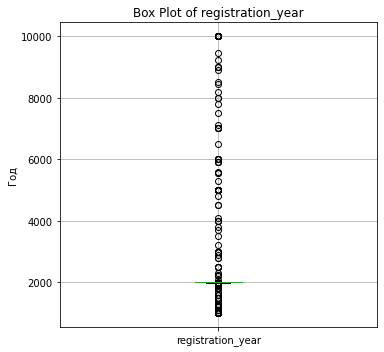

In [34]:
plot_histograms_boxplots(df1[['registration_year']], 'Год')

In [35]:
df.DateCreated.max() #проверим максимальную дату, чтобы удалить ошибочные данные

'2016-04-07 00:00:00'

In [36]:
df1 = df1[(df1['registration_year'] < 2017) & (df1['registration_year']>1900)]

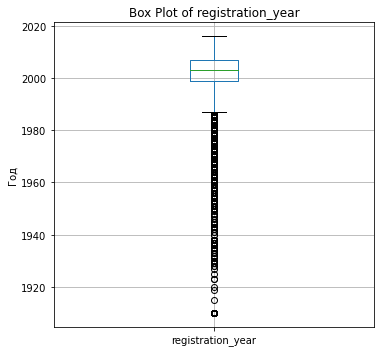

In [37]:
plot_histograms_boxplots(df1[['registration_year']], 'Год')

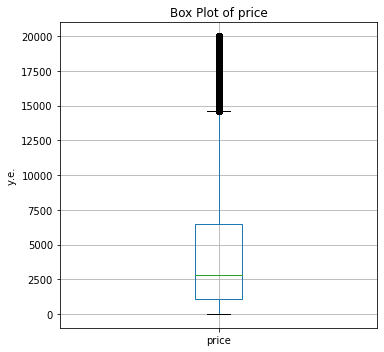

In [38]:
plot_histograms_boxplots(df1[['price']], 'у.е.')

In [39]:
df1 = df1[(df1['price'] > 1000)] #удалим 0 и подозрительно низкие цены (возможно, ошибка или металлолом)

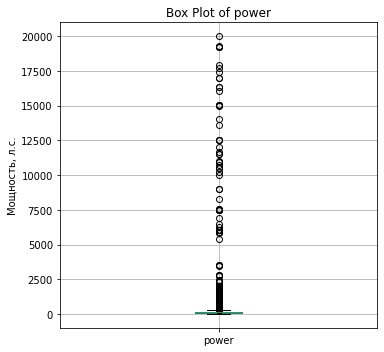

In [40]:
plot_histograms_boxplots(df1[['power']], 'Мощность, л.с.')

In [41]:
df1 = df1[(df1['power'] < 2500) & (df1['power'] > 0)]

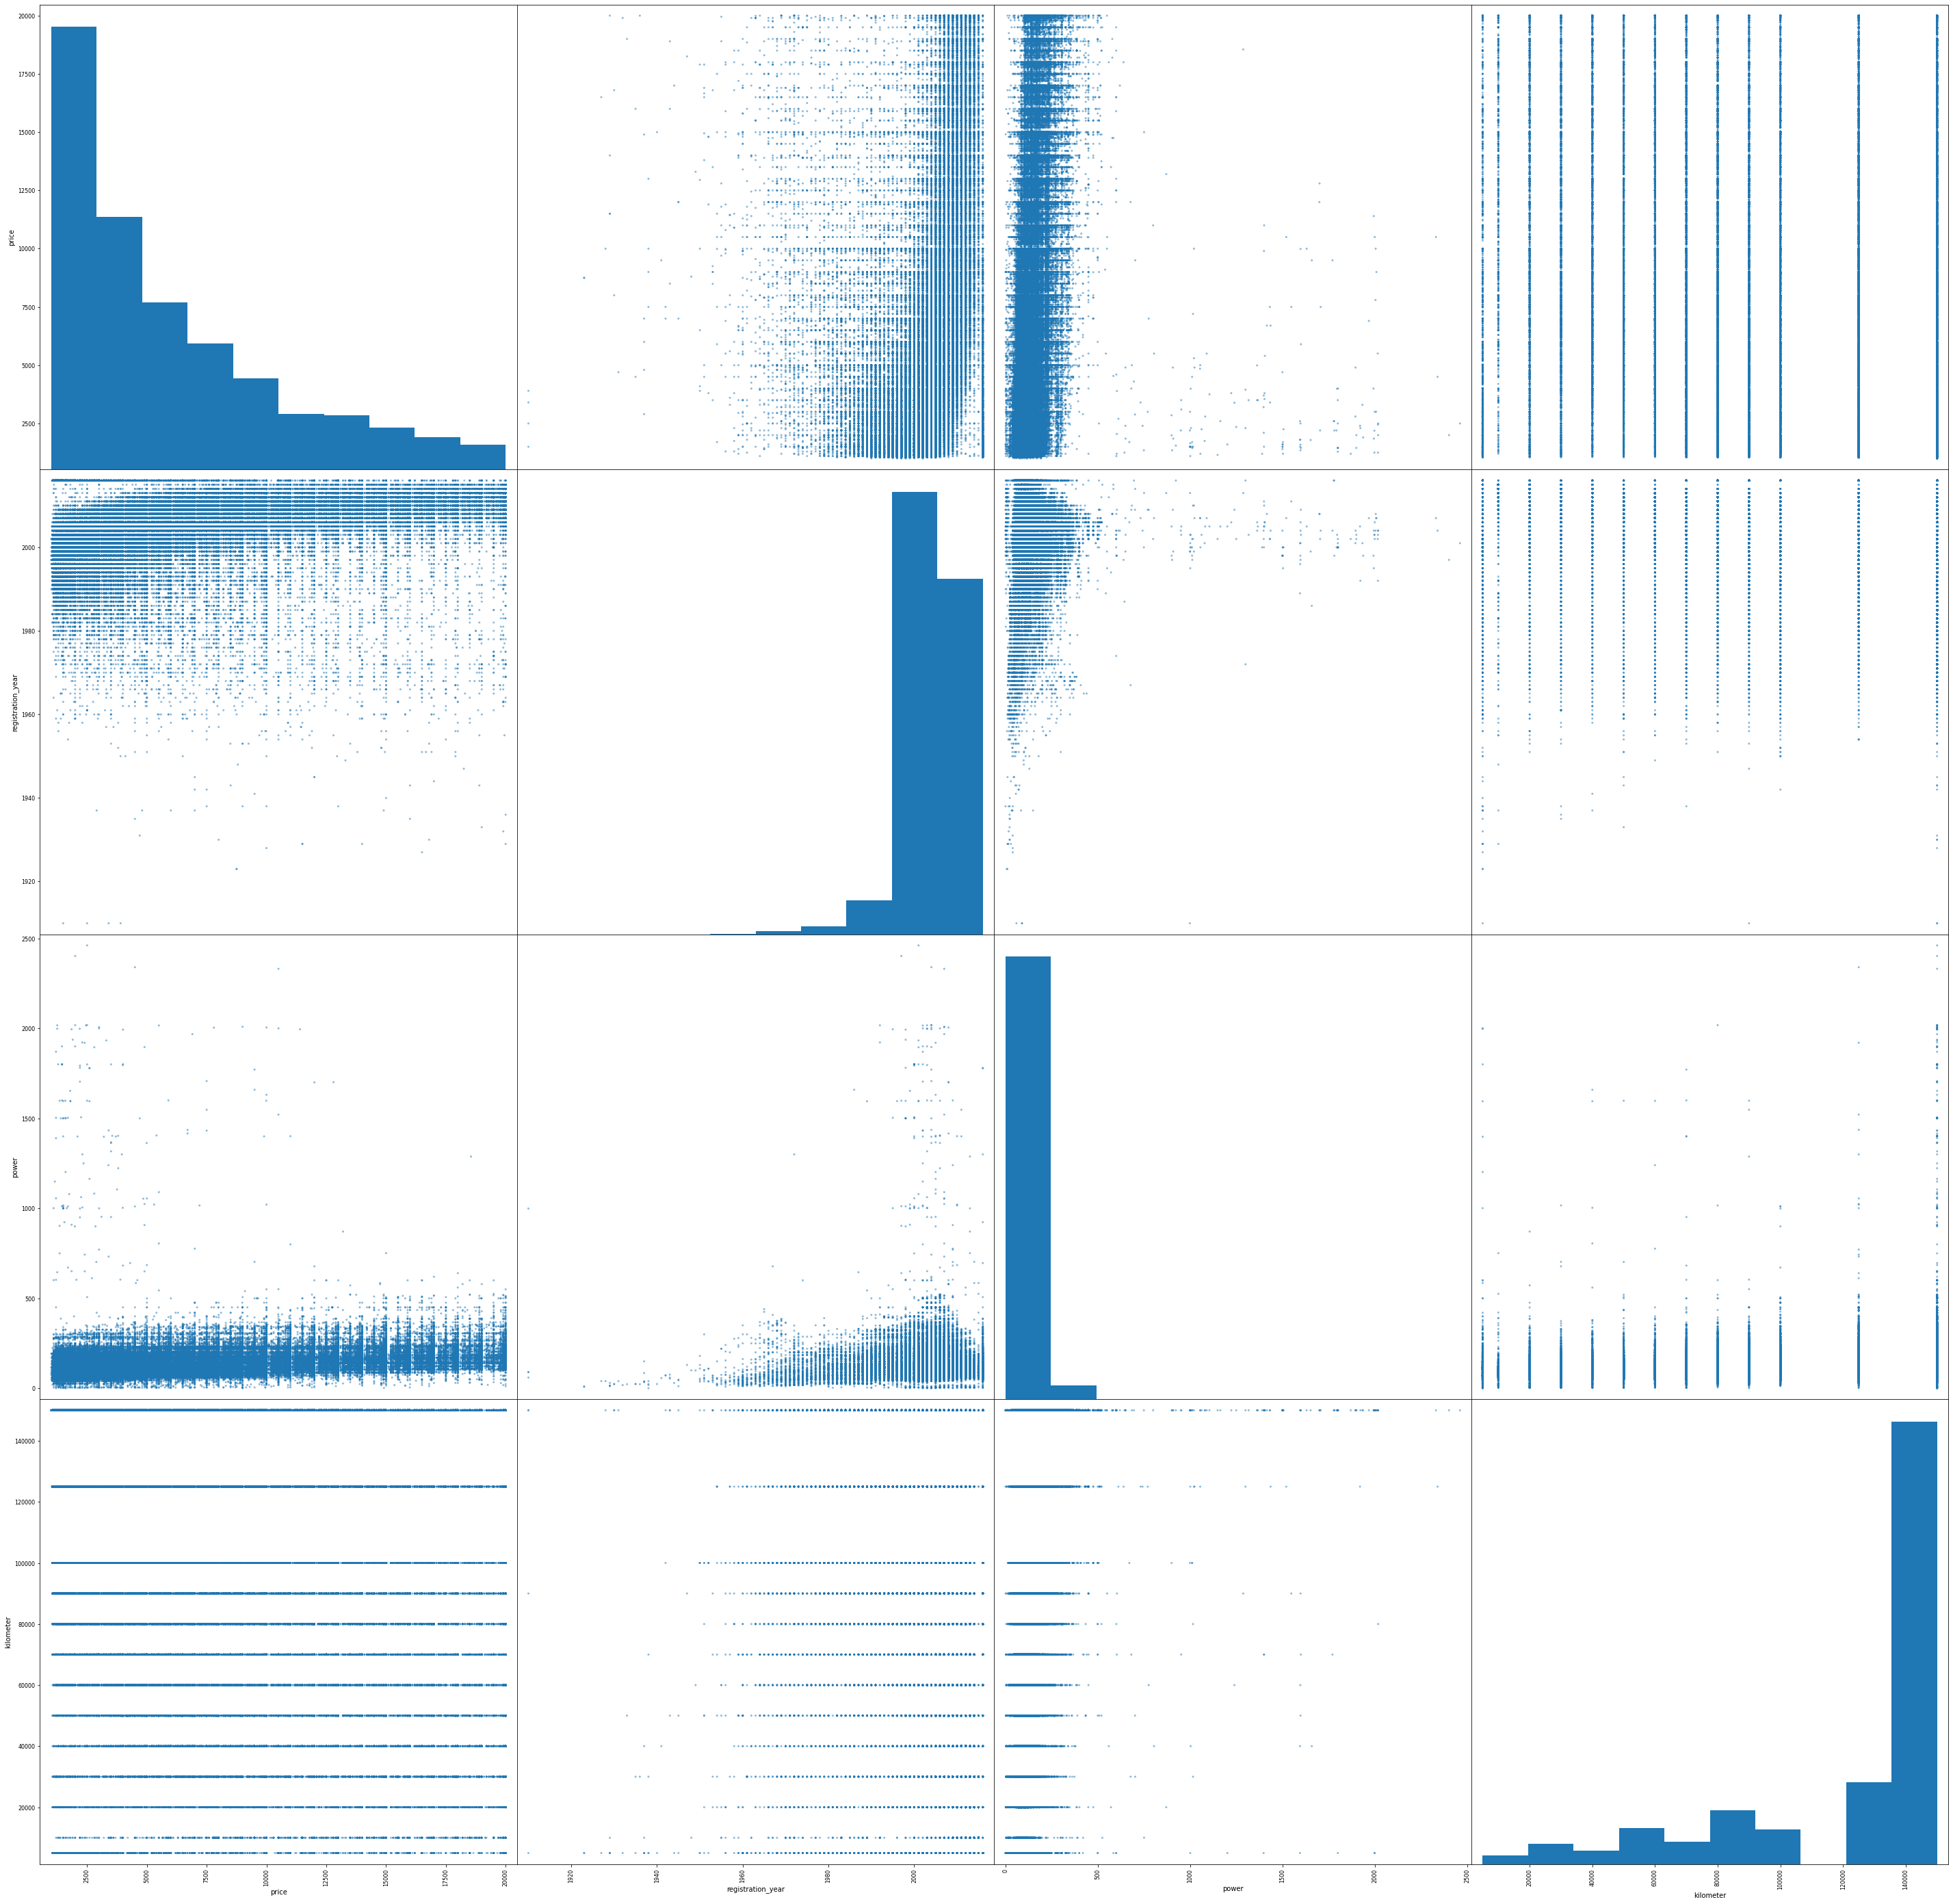

In [42]:
pd.plotting.scatter_matrix(df1, figsize=(50, 50)) 
plt.show()

In [43]:
df1.phik_matrix(interval_cols=['price', 'power'])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.229017,0.637078,0.296841,0.226258,0.536311,0.309678,0.076716,0.288696,0.163899
vehicle_type,0.229017,1.000000,0.595317,0.281519,0.127737,0.915808,0.233512,0.224838,0.609574,0.053468
registration_year,0.637078,0.595317,1.000000,0.079051,0.111370,0.660605,0.652691,0.255684,0.398645,0.061786
gearbox,0.296841,0.281519,0.079051,1.000000,0.286636,0.635645,0.065321,0.106524,0.484402,0.013242
power,0.226258,0.127737,0.111370,0.286636,1.000000,0.413131,0.033296,0.072051,0.226559,0.022118
model,0.536311,0.915808,0.660605,0.635645,0.413131,1.000000,0.460214,0.369187,0.998108,0.084969
kilometer,0.309678,0.233512,0.652691,0.065321,0.033296,0.460214,1.000000,0.099214,0.315550,0.061650
fuel_type,0.076716,0.224838,0.255684,0.106524,0.072051,0.369187,0.099214,1.000000,0.212045,0.030375
brand,0.288696,0.609574,0.398645,0.484402,0.226559,0.998108,0.315550,0.212045,1.000000,0.035158
repaired,0.163899,0.053468,0.061786,0.013242,0.022118,0.084969,0.061650,0.030375,0.035158,1.000000


In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238100 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              238100 non-null  int64 
 1   vehicle_type       238100 non-null  object
 2   registration_year  238100 non-null  int64 
 3   gearbox            238100 non-null  object
 4   power              238100 non-null  int64 
 5   model              238100 non-null  object
 6   kilometer          238100 non-null  int64 
 7   fuel_type          238100 non-null  object
 8   brand              238100 non-null  object
 9   repaired           238100 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.0+ MB


In [45]:
df1 = df1.drop_duplicates()

In [46]:
# КОД РЕВЬЮЕРА
df1.duplicated().sum()

0

**Вывод:** Загрузили данные из файла autos.csv. 


В рамках предобработки переименованы столбцы, заполнены пропущенные значения, удалены дубли (в том числе обработаны неявные дубли моделях и топливе) и обработаны аномалии. Неинформативные признаки удалены: **дата скачивания анкеты из базы, месяц регистрации, дата создания анкеты, дата последней активности пользователя, почтовый индекс владельца анкеты (пользователя)**.


Был проведен исследовательский анализ данных, в рамках которого изучено распределение (нормальное) и корреляция признаков. Были удалены аномальные значения: слишком низкие цены (<1000); неактуальные по году регистрации (1900-2017); слишком высокая мощность (>2500).

## Обучение моделей

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

Подготовка данных

In [47]:
features = df1.drop(['price'], axis=1)
target = df1['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_cols = ['registration_year', 'power', 'kilometer']

In [48]:
oe_processor = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown',)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

data_preprocessor = ColumnTransformer([
    ('cat_oe', oe_processor, cat_cols),
    ('num', StandardScaler(), num_cols)], remainder='passthrough')

pipe_final = Pipeline(
    # Финальный пайплайн
    [('preprocessor', data_preprocessor), ('model', lgb.LGBMRegressor())]
)

In [49]:
# Параметры LGBM регрессии
lgbm_params = {}

lgbm_params['model__n_estimators'] = [1000, 20000]
lgbm_params['model__max_depth'] = [3, 10] 
lgbm_params['model'] = [
    lgb.LGBMRegressor(random_state=RANDOM_STATE, metric='rmse')
]

# Параметры дерева решений

tree_params = {}

tree_params['model__max_depth'] = [2]
tree_params['model__min_samples_split'] = [500, 1000]
tree_params['model'] = [DecisionTreeRegressor(random_state=RANDOM_STATE)]

params = [tree_params, lgbm_params]

In [50]:
grid_reg = GridSearchCV(pipe_final, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1) #rmse_score

In [51]:
start = time()
grid_reg.fit(X_train, y_train)

end = time()
time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды
print("Время: ", time, " минут")

Время:  88.09755470752717  минут


In [52]:
# Сохраним лучшую модель в отдельную переменную
lgbreg = grid_reg.best_estimator_.steps[1][1]

In [53]:
# Узнаем её RMSE
grid_reg.best_score_ * (-1)

1699.9363370237352

In [54]:
ohe_processor = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

data_preprocessor_1 = ColumnTransformer([
    ('cat_ohe', ohe_processor, cat_cols),
    ('num', StandardScaler(), num_cols)], remainder='passthrough')

pipe_final_1 = Pipeline(
    # Финальный пайплайн
    [('preprocessor', data_preprocessor_1), ('model', LinearRegression())]
)

In [55]:
# Параметры линейной регрессии
lreg_params = {}
lreg_params['model'] = [LinearRegression()]
params_1 = [lreg_params]

grid_reg_1 = GridSearchCV(pipe_final_1, params_1, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1) #rmse_score

In [56]:
#start = time()
%timeit grid_reg_1.fit(X_train_1, y_train_1)

#end = time()
#time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды
#print("Время обучения: ", time, " минут")

1min 45s ± 978 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
# Сохраним лучшую модель в отдельную переменную
lreg = grid_reg_1.best_estimator_.steps[1][1]

In [58]:
# Узнаем её RMSE
grid_reg_1.best_score_ * (-1)

2929.179219039163

In [59]:
X_train_prepared = data_preprocessor.fit_transform(X_train)
X_train_prepared_1 = data_preprocessor_1.fit_transform(X_train_1)

In [60]:
# LGBM - время обучения
%timeit  lgbreg.fit(X_train_prepared, y_train)

27.4 s ± 11.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
treereg = DecisionTreeRegressor(random_state=RANDOM_STATE)
lreg = LinearRegression()

In [62]:
# Дерево решений - время обучения
%timeit treereg.fit(X_train_prepared, y_train)

481 ms ± 8.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
# Линейная регрессия - время обучения
%timeit lreg.fit(X_train_prepared_1, y_train_1)

19.4 s ± 562 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
# LGBM - время предсказания
%timeit lgb_pred = lgbreg.predict(X_train_prepared)

17.4 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
# Дерево решений - время предсказания
%timeit tree_pred = treereg.predict(X_train_prepared)

54.4 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
# Линейная регрессия - время предсказания
%timeit lreg_pred = lreg.predict(X_train_prepared_1)

2.38 ms ± 65.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
results_0= pd.DataFrame(grid_reg.cv_results_)
results_1= pd.DataFrame(grid_reg_1.cv_results_)

results = pd.concat([results_0, results_1], ignore_index=True)

# Поиск индексов строк с максимальными значениями метрик
results['model_name'] = results['param_model'].apply(lambda x: str(x).split('(')[0])
max_index = results.groupby('model_name')['mean_test_score'].idxmax()

# Извлечение результатов лучших моделей
best_models = results.loc[max_index]

# Преобразование отрицательных значений метрик в положительные
if 'mean_test_score' in best_models:
    best_models['mean_test_score'] *= -1

# Сортировка результатов по значению метрики
sorted_results = best_models.sort_values(['mean_test_score'], ascending=True).reset_index(drop=True)

# Вывод результатов
print(sorted_results[['model_name','mean_test_score', 'mean_fit_time', 'mean_score_time']])

              model_name  mean_test_score  mean_fit_time  mean_score_time
0          LGBMRegressor      1699.936337      19.236033         3.335191
1       LinearRegression      2929.179219      16.657810         0.248485
2  DecisionTreeRegressor      3340.795482       0.257988         0.052071


Модель LGBM регрессии(по критериям  которые важны заказчику:качество предсказания;время обучения модели; время предсказания модели) лучше, поэтому посчитаем метрику RSME на тестовой выборке.

In [68]:
X_test_prepared = data_preprocessor.transform(X_test)

In [69]:
%timeit 
y_test_pred = lgbreg.predict(X_test_prepared)

In [70]:
# RMSE на тестовой выборке
mean_squared_error(y_test, y_test_pred) ** 0.5

1685.0063797639634

## Анализ моделей

В рамках проекта были изучены предоставленные данные. 
Выполнена предобработка и исследовальский анализ: заполниены пропущенные значения, обработаны дубли, аномалии в столбцах. 
Часть признаков признали неинформативными и удалили их.

Подготовили выборки для обучения моделей.

подобрали параметры и обучили три модели - LGBM, линейная регрессия и дерево решений.

Проанализиров время обучения, время предсказания и качество моделей (критерии заказчика) выбрали лучшую модель LGBM (по оптимальной совокупности критериев заказчика: качество предсказания; скорость предсказания; время обучения.), проверили её качество на тестовой выборке (**RMSE на тестовой выборке - 1685.00**).